<a href="https://colab.research.google.com/github/oakhtar147/hyperparameter-tuning/blob/main/keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install keras-tuner
clear_output()

In [ ]:
!nvidia-smi

Fri Dec 11 16:46:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   1893MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from kerastuner.tuners.randomsearch import RandomSearch
from kerastuner.tuners.hyperband import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import time
import warnings

In [ ]:
warnings.filterwarnings('ignore')
LOG_DIR = "/content/drive/MyDrive/logs"

In [ ]:
#load Mnist dataset and visualize the first 10 pics in training and testing
(X_train, y_train), (X_test,y_test) = fashion_mnist.load_data() 
# X_train.setflags(write=1)
# y_train.setflags(write=1)
# X_test.setflags(write=1)
# y_test.setflags(write=1)

In [ ]:
class_mapping = {0: 'T-shirt/top', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
    }

Train Images


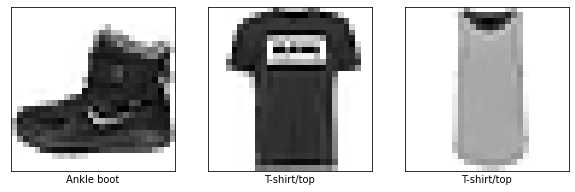

In [ ]:
fig = plt.figure(figsize=(10,10))
print("Train Images")
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_mapping[y_train[i]])

Test Images


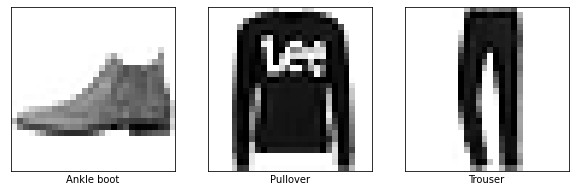

In [ ]:
fig = plt.figure(figsize=(10,10))
print("Test Images")
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_mapping[y_test[i]])

In [ ]:
# data normalization and preparation
X_train = X_train/255.
X_test = X_test/255.

y_train = to_categorical(y_train,)
y_test = to_categorical(y_test)

IMG_ROWS, IMG_COLS = 28, 28
if backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, IMG_ROWS, IMG_COLS)
    X_test = x_test.reshape(X_test.shape[0], 1, IMG_ROWS, IMG_COLS)
    input_shape = (1, IMG_ROWS, IMG_COLS)
else:
    X_train = X_train.reshape(X_train.shape[0], IMG_ROWS, IMG_COLS, 1)
    X_test = X_test.reshape(X_test.shape[0], IMG_ROWS, IMG_COLS, 1)
    input_shape = (IMG_ROWS, IMG_COLS, 1)

In [ ]:
# define keras model and return model history
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
    for layer in range(hp.Int('layer_count', min_value=2, max_value=5)):
        model.add(Conv2D(hp.Int(f'conv_{layer}', min_value=32, max_value=256, step=32), hp.Choice(f'conv_{layer}_fsize', values=[3, 5]), activation='relu', padding='same'))

    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=10, max_value=200, step=40), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(hp.Choice('lr', values=[0.0001, 0.001, 0.01])),metrics=['accuracy'])

    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory=LOG_DIR,
    project_name="keras_tuner"
)

In [ ]:
start = time.time()
tuner.search(X_train, y_train, 
        epochs=3, 
        validation_data=(X_test, y_test) 
    )
print(f"It took {time.time() - start:.2f}s to complete this search")

Trial 15 Complete [00h 02m 10s]
val_accuracy: 0.758400022983551

Best val_accuracy So Far: 0.9279000163078308
Total elapsed time: 00h 19m 22s
INFO:tensorflow:Oracle triggered exit
It took 1162.78s to complete this search


In [ ]:
best_model_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
lr = best_model_hyperparameters.get('lr')
lr
# you can get other best hyperparameters you dynamically set as well

0.0001

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary() # keras model that you can further train

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 160)       128160    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 192)       276672    
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 192)       768       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 192)       0         
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 170)               6

In [ ]:
tuner.results_summary(num_trials=15)

Results summary
Results in /content/drive/MyDrive/logs/keras_tuner
Showing 15 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layer_count: 2
conv_0: 160
conv_0_fsize: 5
conv_1: 192
conv_1_fsize: 3
dense_units: 170
lr: 0.0001
conv_2: 160
conv_2_fsize: 3
conv_3: 32
conv_3_fsize: 3
Score: 0.9279000163078308
Trial summary
Hyperparameters:
layer_count: 4
conv_0: 192
conv_0_fsize: 3
conv_1: 32
conv_1_fsize: 3
dense_units: 130
lr: 0.0001
conv_2: 96
conv_2_fsize: 5
conv_3: 160
conv_3_fsize: 3
Score: 0.9279000163078308
Trial summary
Hyperparameters:
layer_count: 2
conv_0: 224
conv_0_fsize: 3
conv_1: 96
conv_1_fsize: 5
dense_units: 170
lr: 0.0001
conv_2: 32
conv_2_fsize: 3
conv_3: 160
conv_3_fsize: 3
Score: 0.9275000095367432
Trial summary
Hyperparameters:
layer_count: 3
conv_0: 96
conv_0_fsize: 3
conv_1: 64
conv_1_fsize: 3
dense_units: 90
lr: 0.0001
conv_2: 224
conv_2_fsize: 3
conv_3: 128
conv_3_fsize: 5
Score: 0.9265000224113464
Trial summary
Hyperpar